# Import libraries

In [21]:
import pandas as pd
import numpy as np
import os
import config
from joblib import dump, load
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib import rc
from GMHI import GMHI

# Set constants

In [22]:
# set figure details
dpi = 200

# set colors
healthy_color = "steelblue"
nonhealthy_color = 'orange'
both_color = 'magenta'

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Load data

In [23]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features.csv"), index_col=[0, 1])
y = pd.read_csv(os.path.join(config.CLEAN_DIR, "is_healthy.csv"), index_col=[0, 1])
GMHI2_scores_cv = pd.read_csv(os.path.join(config.PREDICTION_DIR, "GMHI2_scores_cv.csv"), index_col=[0, 1])
display(X.head())
display(y.head())
display(GMHI2_scores_cv.head())

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID Sample Accession                                            
GMHI-10  SAMN03283239        0.000000                     0.000000   
         SAMN03283266        0.000000                     0.000000   
         SAMN03283281        0.009764                     0.009764   
         SAMN03283245        0.106067                     0.106067   
         SAMN03283294        0.000000                     0.000000   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID Sample Accession                                                   
GMHI-10  SAMN03283239                                            0.000000   
         SAMN03283266                                            0.000000   
         SAMN03283281                                            0.009764   
         SAMN03283245                                            0.106067   
         SAMN03283294                                            0.000000   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID Sample Accession                                                                         
GMHI-10  SAMN03283239                                               0.000000                      
         SAMN03283266                                               0.000000                      
         SAMN03283281                                               0.009764                      
         SAMN03283245                                               0.106067                      
         SAMN03283294                                               0.000000                      

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID Sample Accession                                                                                                
GMHI-10  SAMN03283239                                               0.000000                                             
         SAMN03283266                                               0.000000                                             
         SAMN03283281                                               0.009764                                             
         SAMN03283245                                               0.106067                                             
         SAMN03283294                                               0.000000                                             

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Study_ID Sample Accession                                                                                                                      
GMHI-10  SAMN03283239                                               0.000000                                                                   
         SAMN03283266                                               0.000000                                                                   
         SAMN03283281                                               0.009764                                                                   
         SAMN03283245                                               0.072453                                                                   
         SAMN03283294                                               0.000000                                                                   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID Sample Accession                                                                                                                                                    
GMHI-10  SAMN03283239                                               0.000000              

PHENOTYPE:Healthy_Nonhealthy
Study_ID Sample Accession                              
GMHI-10  SAMN03283239                              True
         SAMN03283266                              True
         SAMN03283281                              True
         SAMN03283245                              True
         SAMN03283294                              True

GMHI2_cv
Study_ID Sample Accession          
GMHI-10  SAMN03283239      1.876379
         SAMN03283266      0.273884
         SAMN03283281      0.942891
         SAMN03283245      1.152237
         SAMN03283294      2.140906

# Plot bar plot performance

In [30]:
def get_study_scores(index_scores, y, scoring_func, cutoff=0):
    scores = []
    for study in np.unique(index_scores.index.get_level_values(0)):
        y_curr = y.loc[study]
        index_curr = index_scores.loc[study]
        idx = (abs(index_curr) >= cutoff).values
        score = scoring_func(y_curr[idx], index_curr[idx] > 0)
        scores.append(
            {
                "study" : study,
                "score" : score
            }
        )
        
    df = pd.DataFrame(scores)
    return df.set_index("study")

In [31]:
def plot_performance_per_study_bar(yaxis_label, scoring_func, cutoff, filename):
    GMHI2_study_scores = get_study_scores(GMHI2_scores_cv, y, scoring_func, cutoff=cutoff)
    
    # rank order studies
    GMHI2_study_scores = GMHI2_study_scores.sort_values("score", ascending=False)
    
    # set colors based on phenotypes in studies
    colors = np.array([
        healthy_color if float(y.loc[s].mean()) == 1 else \
        nonhealthy_color if float(y.loc[s].mean()) == 0 else both_color 
        for s in GMHI2_study_scores.index
    ])
    
    # get means of each group of study
    means = dict([(col, float(GMHI2_study_scores[colors == col].mean())) for col in np.unique(colors)])
    total_mean = float(GMHI2_study_scores.mean())
    print("total mean:", total_mean)
    
    
    # plot stuff!!!
    fig = plt.figure(figsize=(10, 5), dpi=dpi)
    ax = plt.gca()
    
    # draw lines for means
    print(means)
    for col in means:
        ax.axhline(y=means[col], color=col, linestyle='--')
    ax.axhline(y=total_mean, color='black', linestyle='--')

    plt.bar(np.arange(0, GMHI2_study_scores.shape[0]), GMHI2_study_scores["score"].values, color=colors)
    ax.tick_params(axis="both", labelsize=20)

    ax.set_ylabel(yaxis_label, fontsize=20)
    ax.set_xlabel("Rank (study)", fontsize=20)
    plt.yticks(np.arange(0, 1.1, 0.1))

    ax.set_axisbelow(True)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    handles = [
        Patch(facecolor=healthy_color, edgecolor="k", label="Healthy", alpha=1),
        Patch(facecolor=nonhealthy_color, edgecolor="k", label="Nonhealthy", alpha=1),
        Patch(facecolor=both_color, edgecolor="k", label="Both", alpha=1),
    ]

    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(handles=handles, prop={'size': 14}, loc=1, handlelength=1.4, handleheight=1.4)

    ax.grid(linestyle = '--', linewidth = 0.75, axis="y")
    plt.savefig(os.path.join(config.FIGURE_DIR, filename), bbox_inches='tight')

total mean: 0.7067937829210095
{'magenta': 0.6045037964914196, 'orange': 0.7133789811456269, 'steelblue': 0.8036298779745495}
total mean: 0.7159498706229621
{'magenta': 0.6077126587374481, 'orange': 0.727906796813608, 'steelblue': 0.8172648221611921}
total mean: 0.7768576934592769
{'magenta': 0.6489642668345599, 'orange': 0.8142697618985122, 'steelblue': 0.8911985878816812}


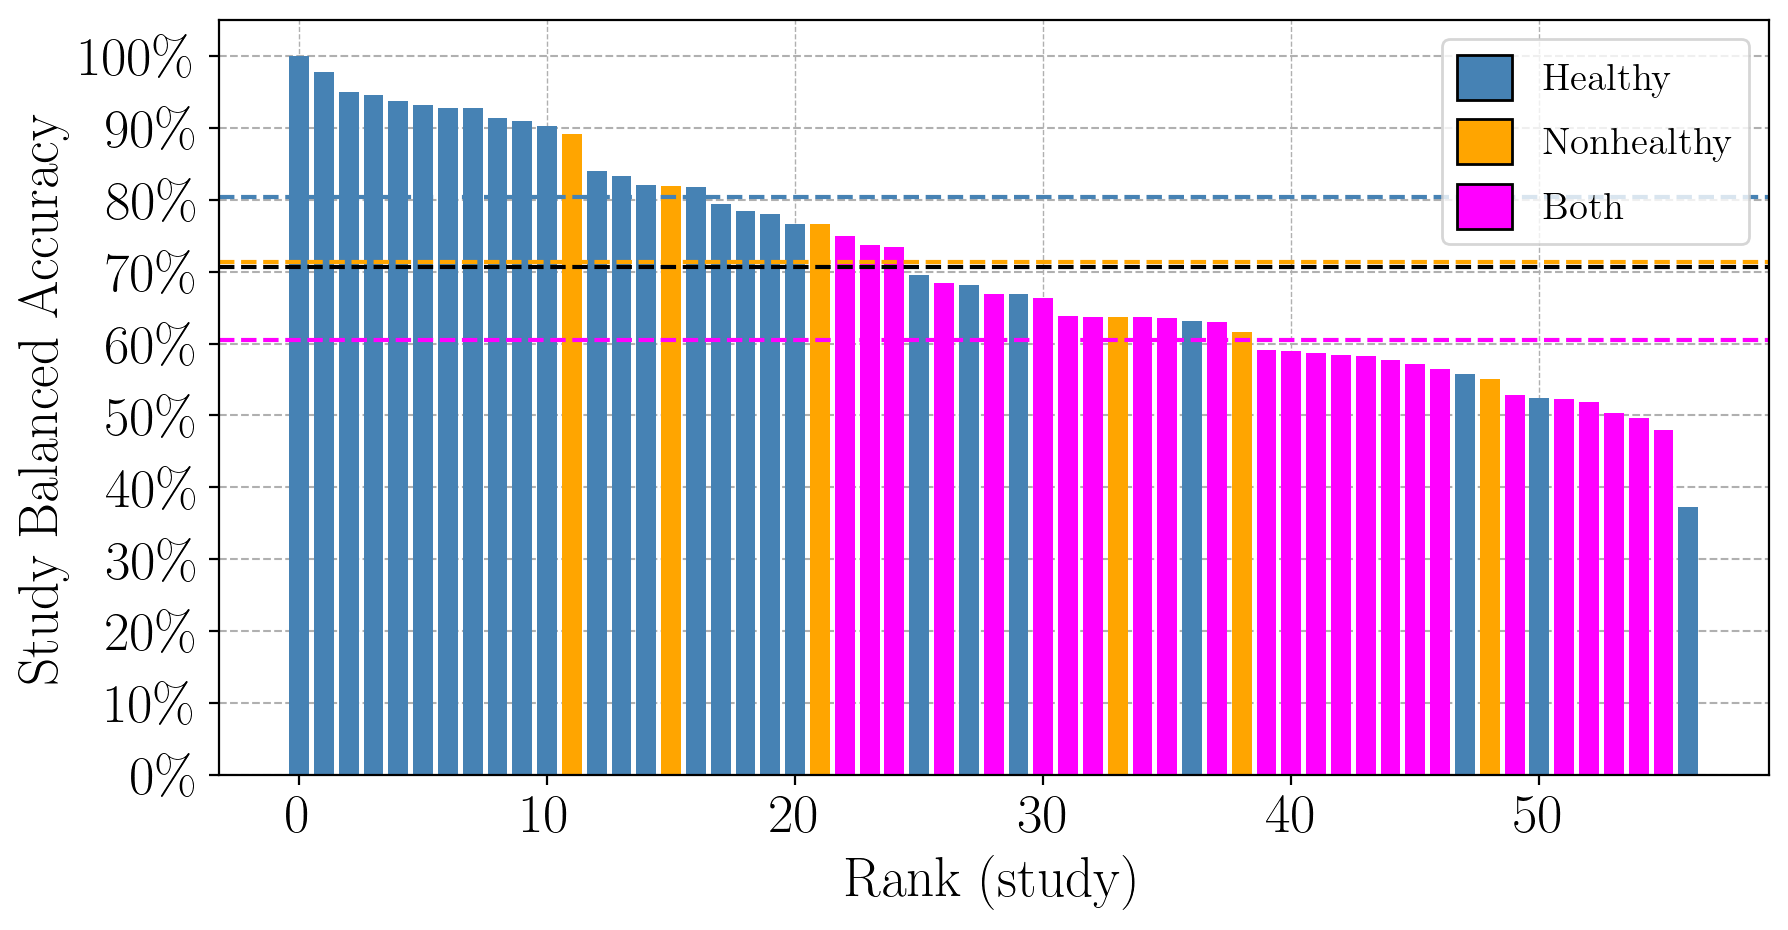

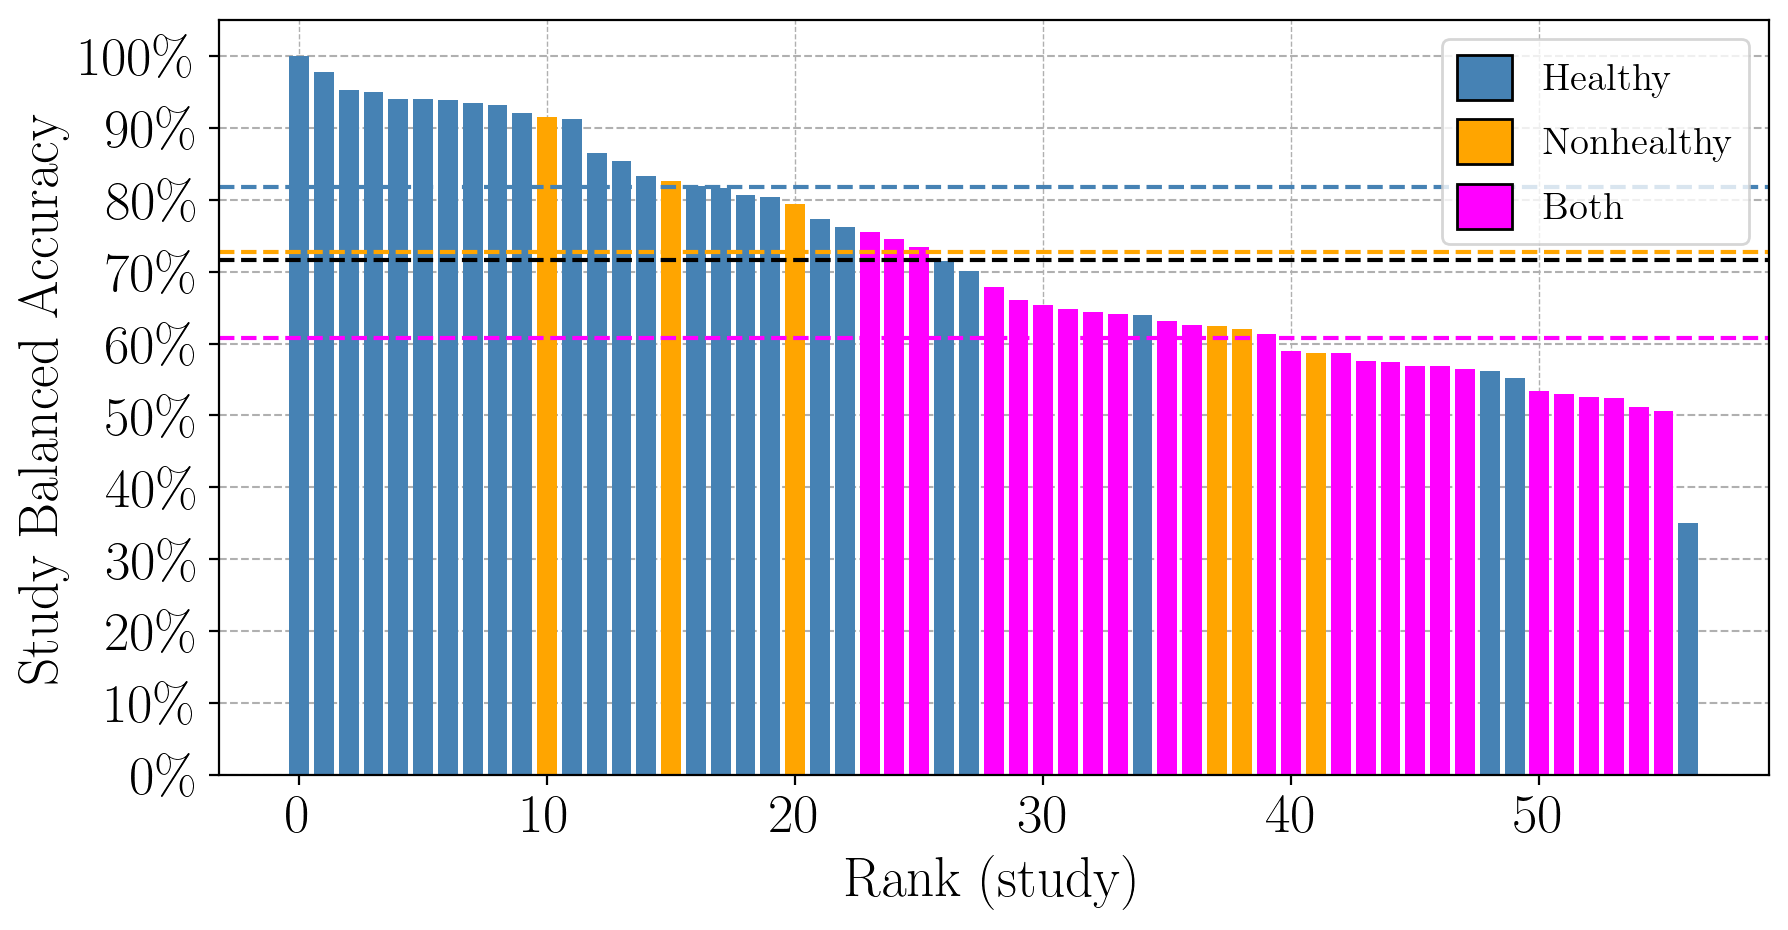

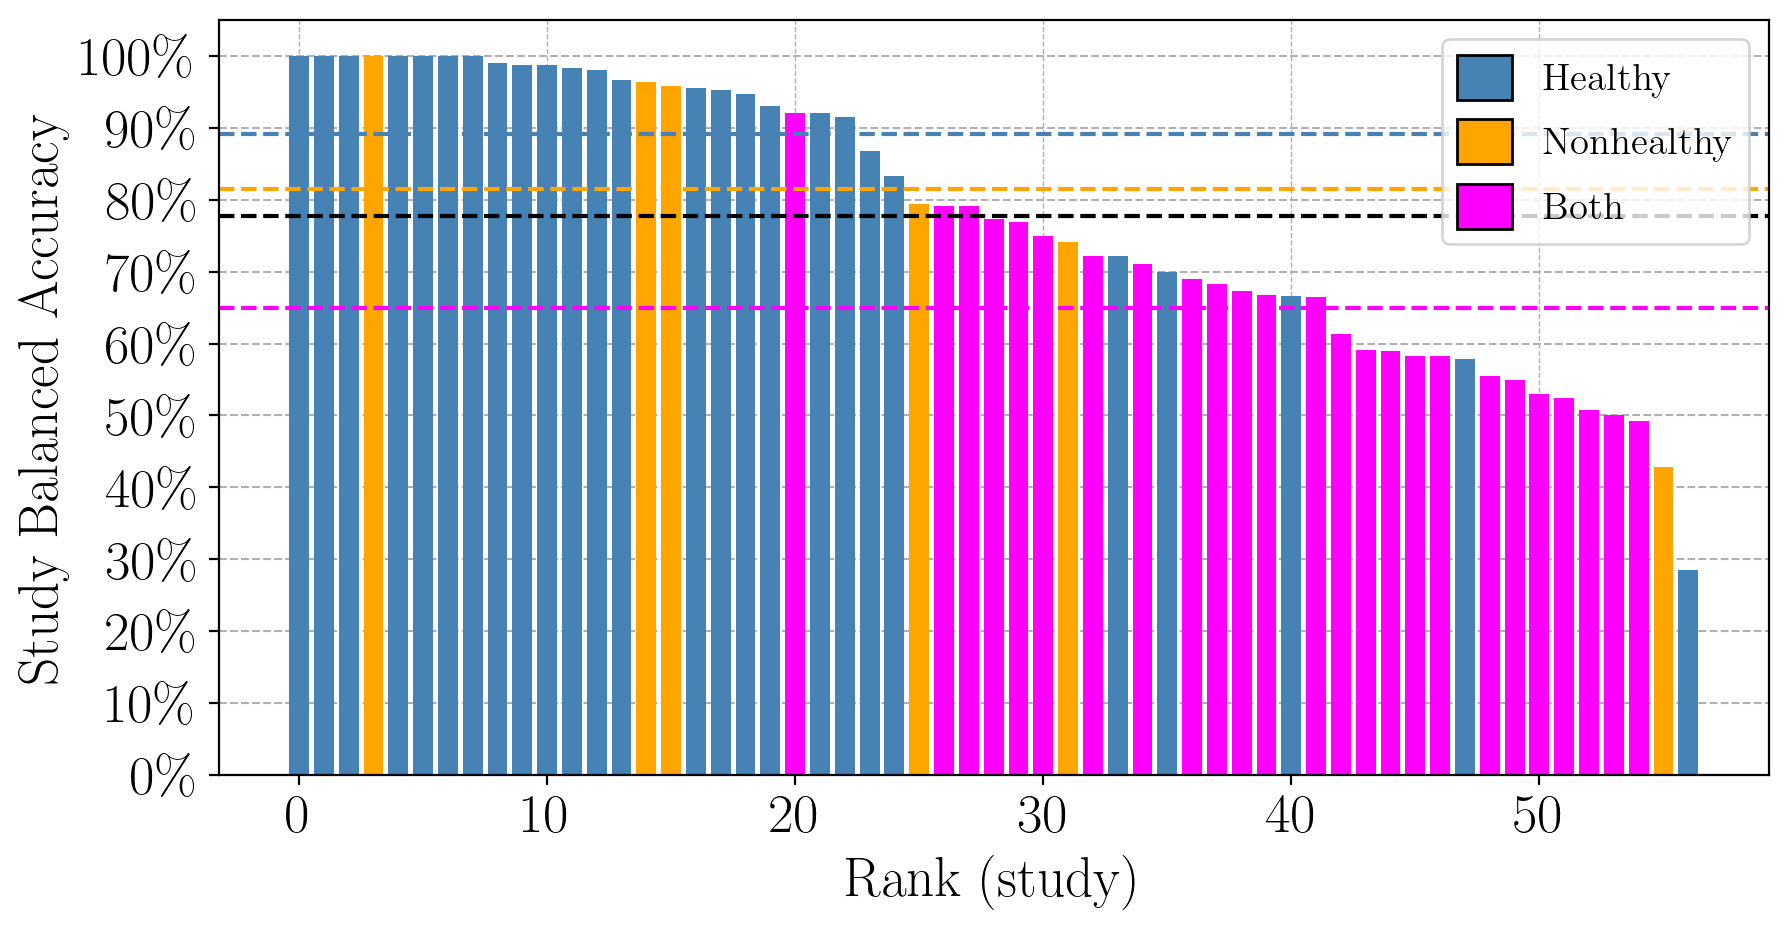

In [34]:
plot_performance_per_study_bar("Study Balanced Accuracy", balanced_accuracy_score, 0, "balanced_accuracy_per_study_bar_cutoff=0.svg")
plot_performance_per_study_bar("Study Balanced Accuracy", balanced_accuracy_score, 0.1, "balanced_accuracy_per_study_bar_cutoff=0.1.svg")
plot_performance_per_study_bar("Study Balanced Accuracy", balanced_accuracy_score, 1, "balanced_accuracy_per_study_bar_cutoff=1.svg")


total mean: 0.715023714548822
{'magenta': 0.6232680406028321, 'orange': 0.7133789811456269, 'steelblue': 0.8036298779745495}
total mean: 0.7251416236919667
{'magenta': 0.6286698557347784, 'orange': 0.727906796813608, 'steelblue': 0.8172648221611921}
total mean: 0.8048802581596427
{'magenta': 0.712855714351394, 'orange': 0.8142697618985122, 'steelblue': 0.8911985878816812}


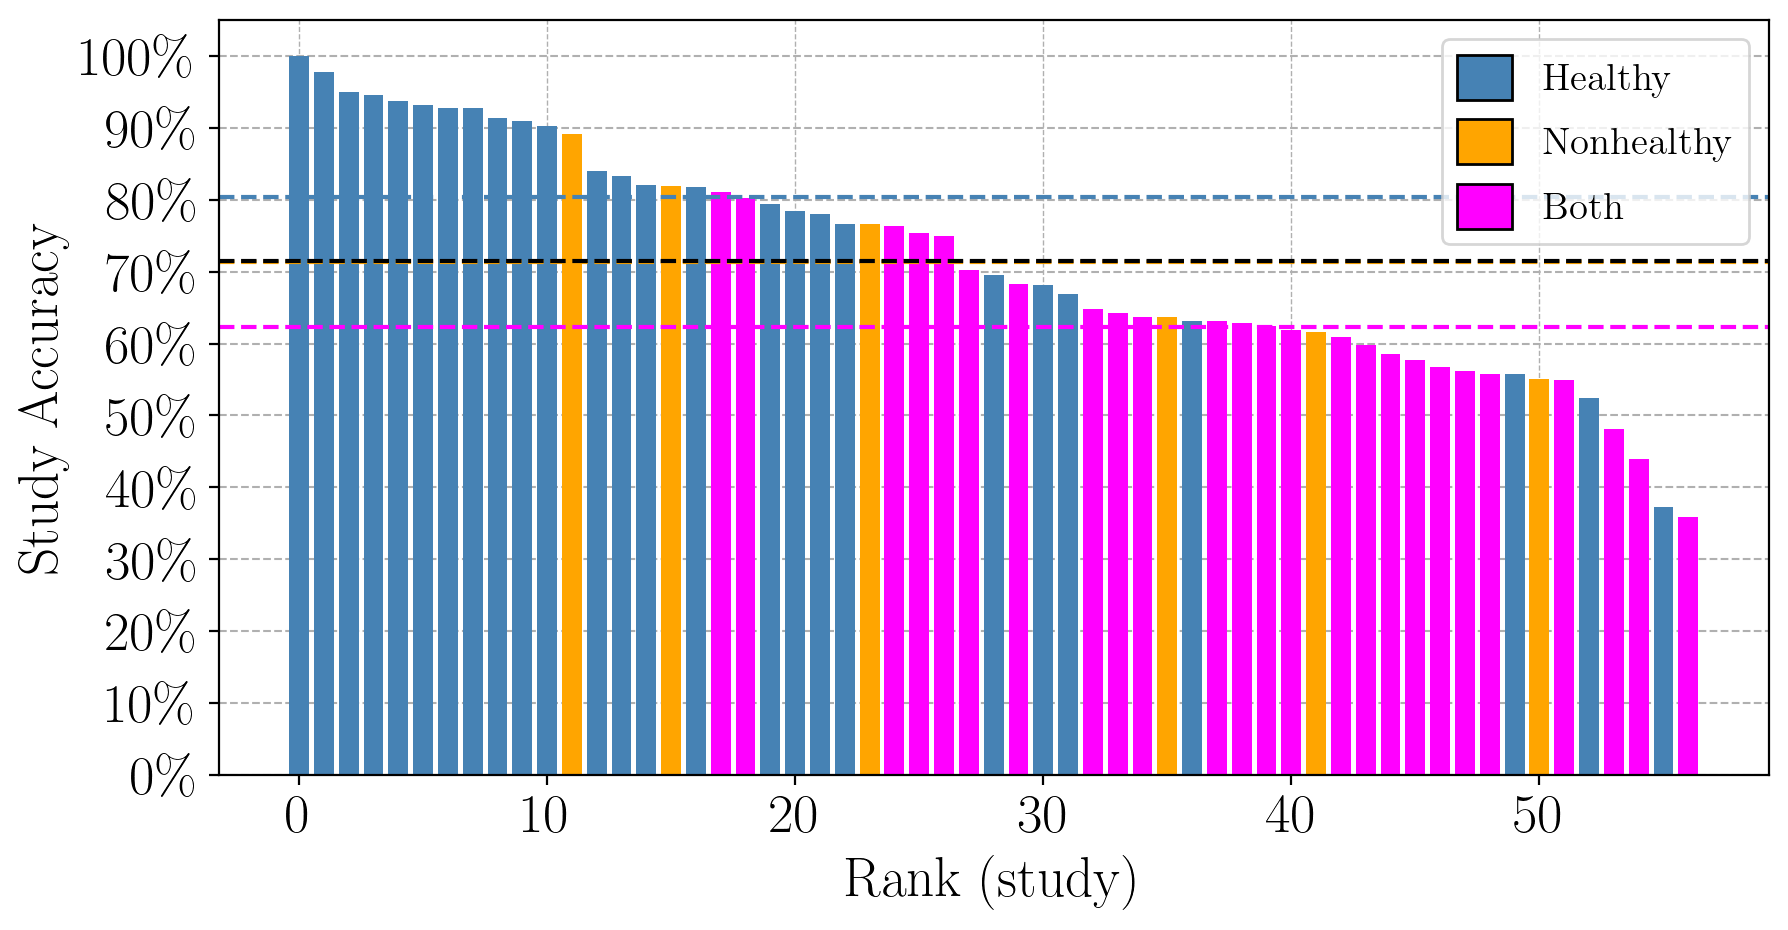

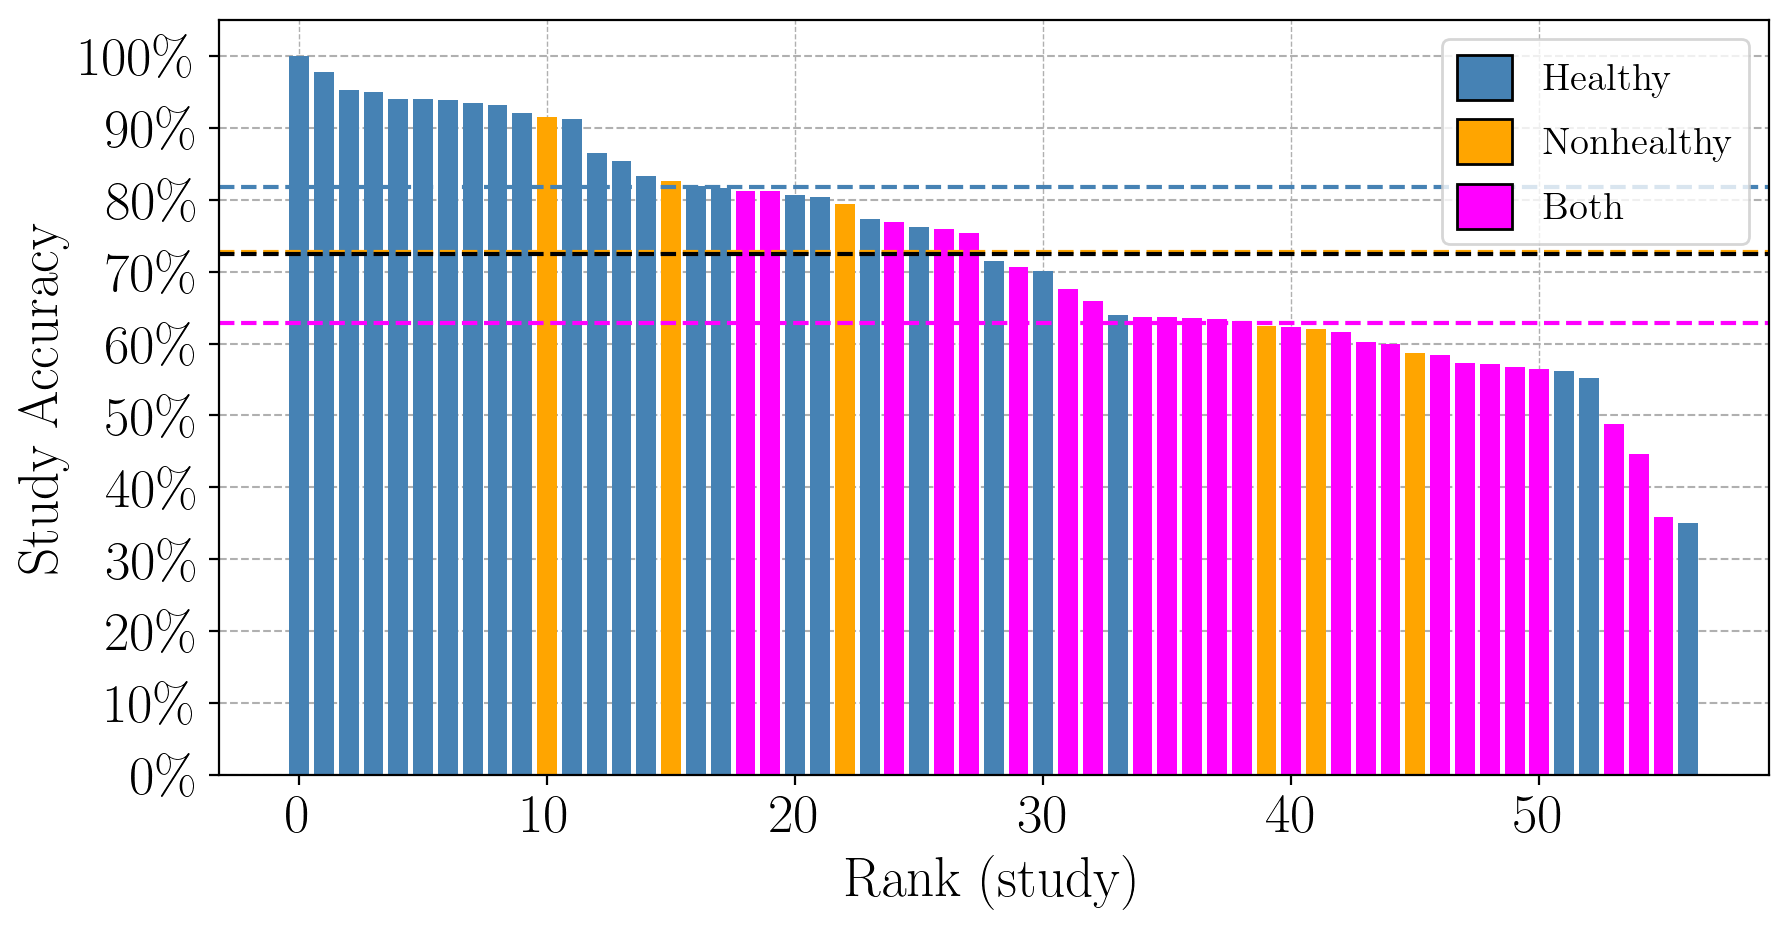

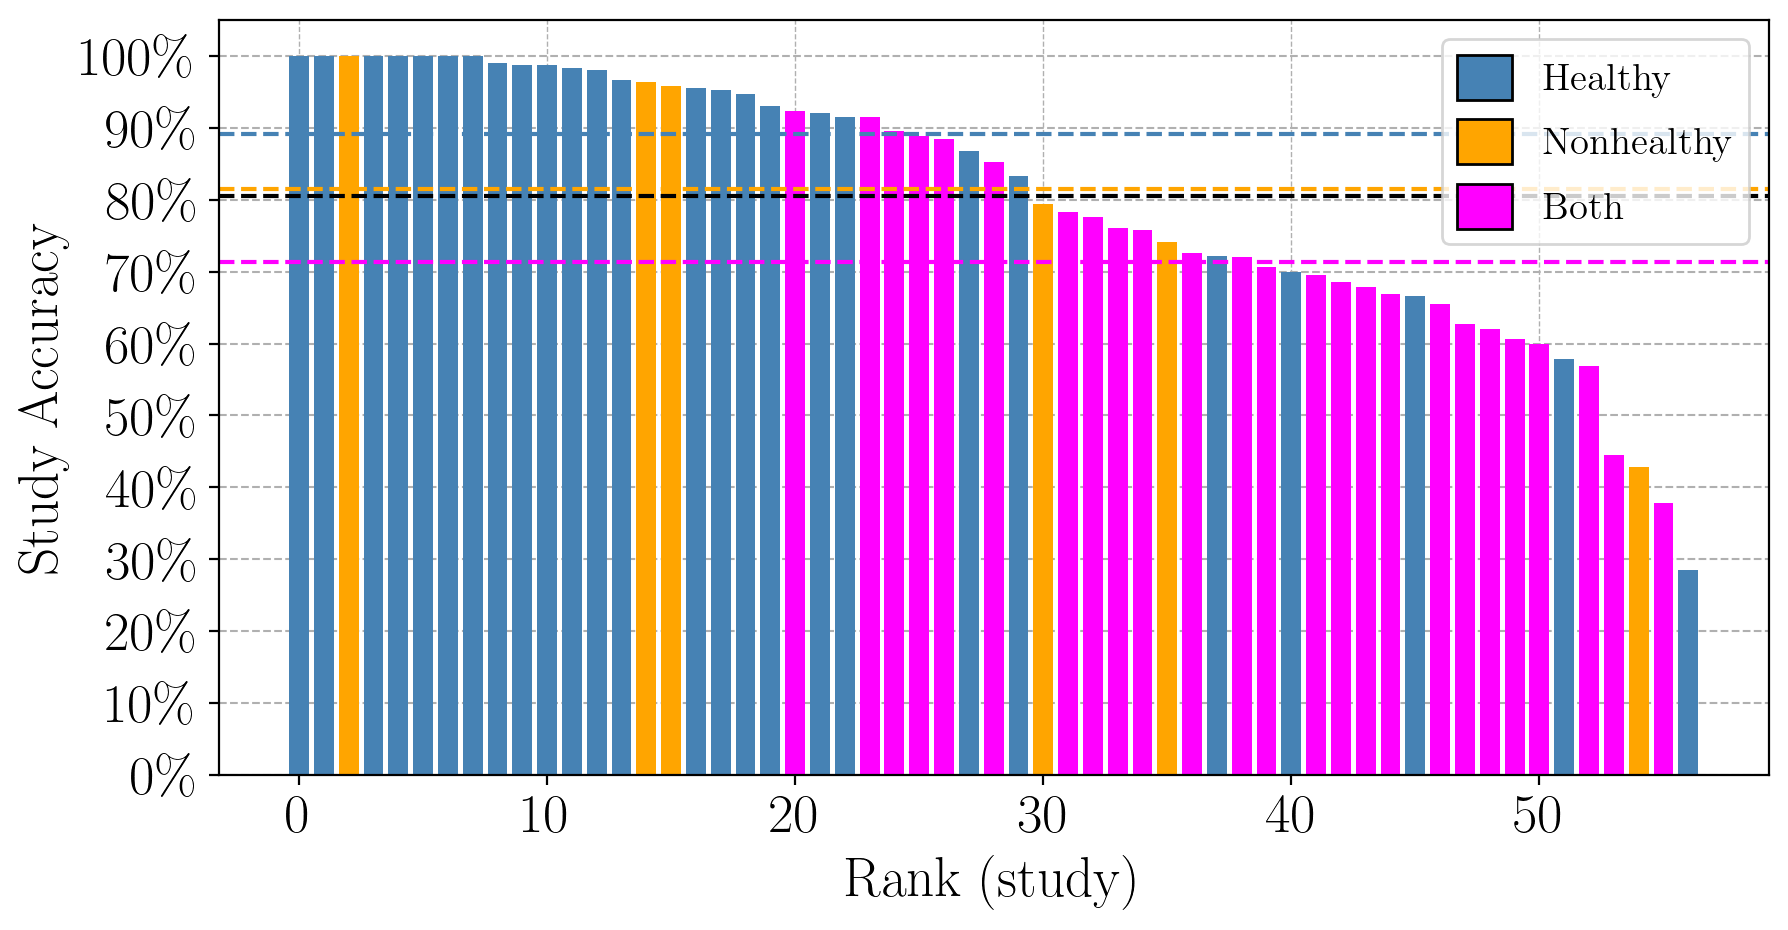

In [36]:
plot_performance_per_study_bar("Study Accuracy", accuracy_score, 0, "accuracy_per_study_bar_cutoff=0.svg")
plot_performance_per_study_bar("Study Accuracy", accuracy_score, 0.1, "accuracy_per_study_bar_cutoff=0.1.svg")
plot_performance_per_study_bar("Study Accuracy", accuracy_score, 1, "accuracy_per_study_bar_cutoff=1.svg")

# Plot scatter performance

In [37]:
def plot_performance_per_study_scatter(yaxis_label, scoring_func, cutoff, filename):
    # get study scores
    GMHI2_study_scores = get_study_scores(GMHI2_scores_cv, y, scoring_func, cutoff=cutoff)
    
    # get sample sizes 
    sample_sizes_sorted = GMHI2_scores_cv.groupby(level=0).count().sort_values(by="GMHI2_cv")
    ascending_index = sample_sizes_sorted.index
    
    # sort studies by sample sizes
    df = pd.DataFrame(sample_sizes_sorted)
    df.columns = ["sample_size"]
    df[yaxis_label] = GMHI2_study_scores.loc[ascending_index]
    
    # set colors based on phenotypes in studies
    colors = np.array([
        healthy_color if float(y.loc[s].mean()) == 1 else \
        nonhealthy_color if float(y.loc[s].mean()) == 0 else both_color 
        for s in df.index
    ])
    
    # plot stuff
    plt.figure(figsize=(10, 5), dpi=dpi)
    
    ax = plt.gca()
    
    plt.scatter(df["sample_size"], df[yaxis_label], c=colors)
    
    ax.tick_params(axis="both", labelsize=20)

    ax.set_ylabel(yaxis_label, fontsize=20)
    ax.set_xlabel("Study Sample Size", fontsize=20)
#     plt.yticks(np.arange(0, 1.1, 0.1))

    ax.set_axisbelow(True)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    handles = [
        Patch(facecolor=healthy_color, edgecolor="k", label="Healthy", alpha=1),
        Patch(facecolor=nonhealthy_color, edgecolor="k", label="Nonhealthy", alpha=1),
        Patch(facecolor=both_color, edgecolor="k", label="Both", alpha=1),
    ]

    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(handles=handles, prop={'size': 14}, loc=0, handlelength=1.4, handleheight=1.4)
    plt.savefig(os.path.join(config.FIGURE_DIR, filename), bbox_inches='tight')

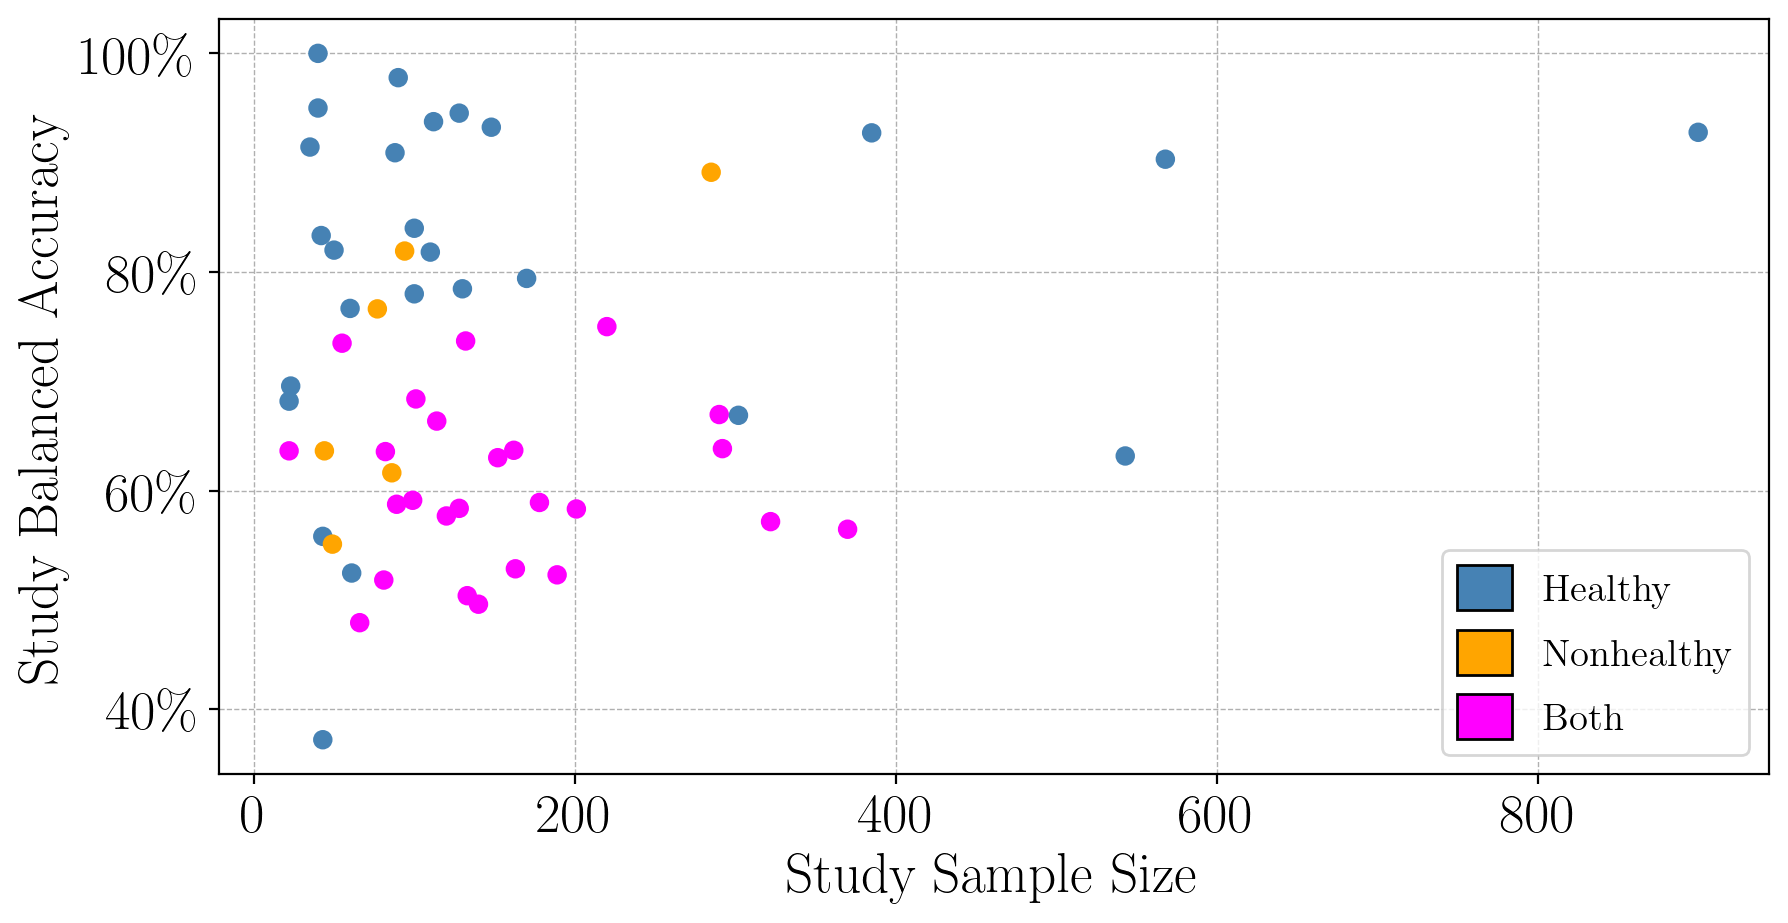

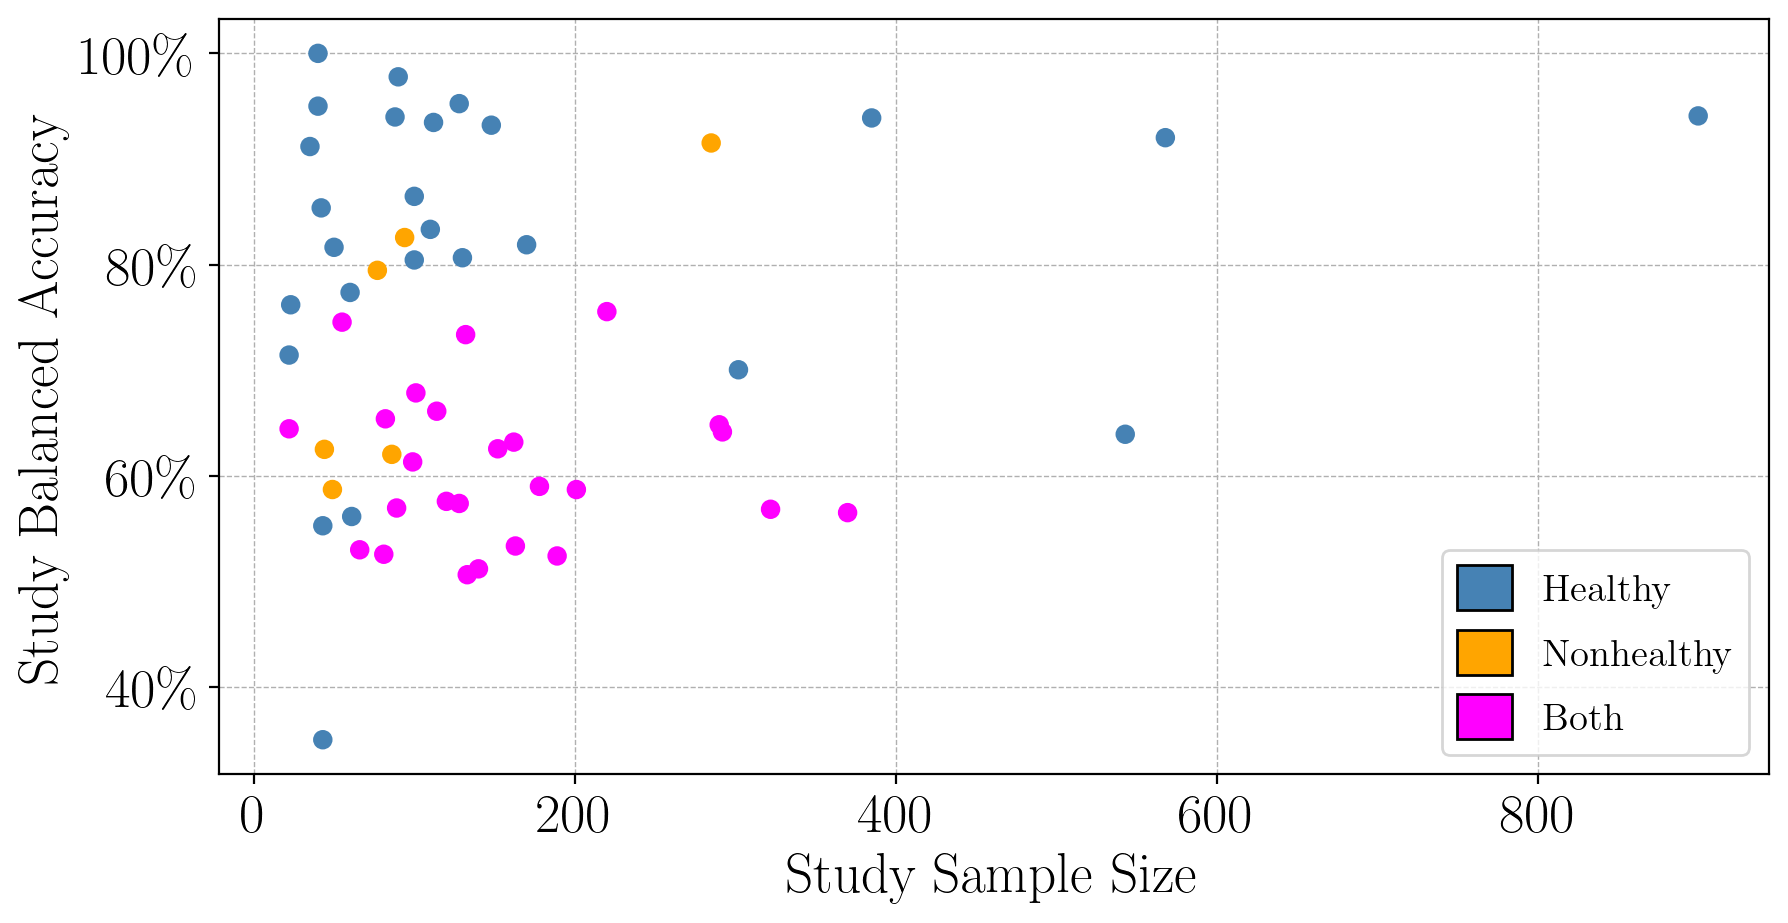

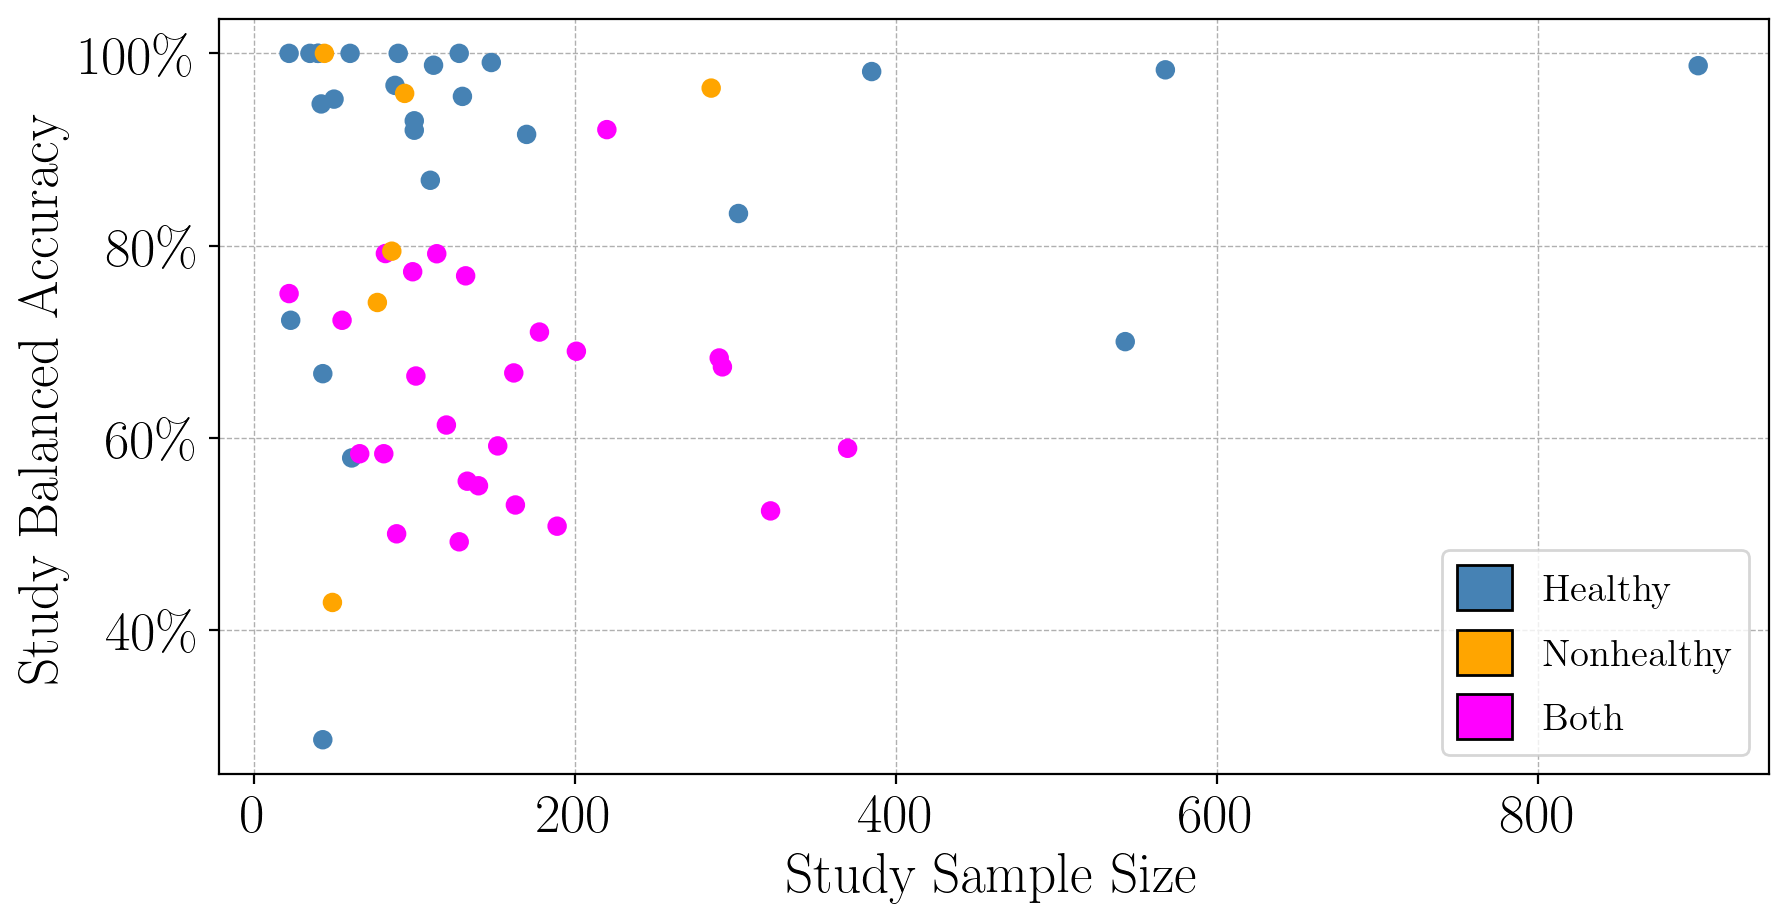

In [39]:
plot_performance_per_study_scatter("Study Balanced Accuracy", balanced_accuracy_score, 0,
                                   "balanced_accuracy_per_study_scatter_cutoff=0.svg")
plot_performance_per_study_scatter("Study Balanced Accuracy", balanced_accuracy_score, 0.1,
                                   "balanced_accuracy_per_study_scatter_cutoff=0.1.svg")
plot_performance_per_study_scatter("Study Balanced Accuracy", balanced_accuracy_score, 1,
                                   "balanced_accuracy_per_study_scatter_cutoff=1.svg")

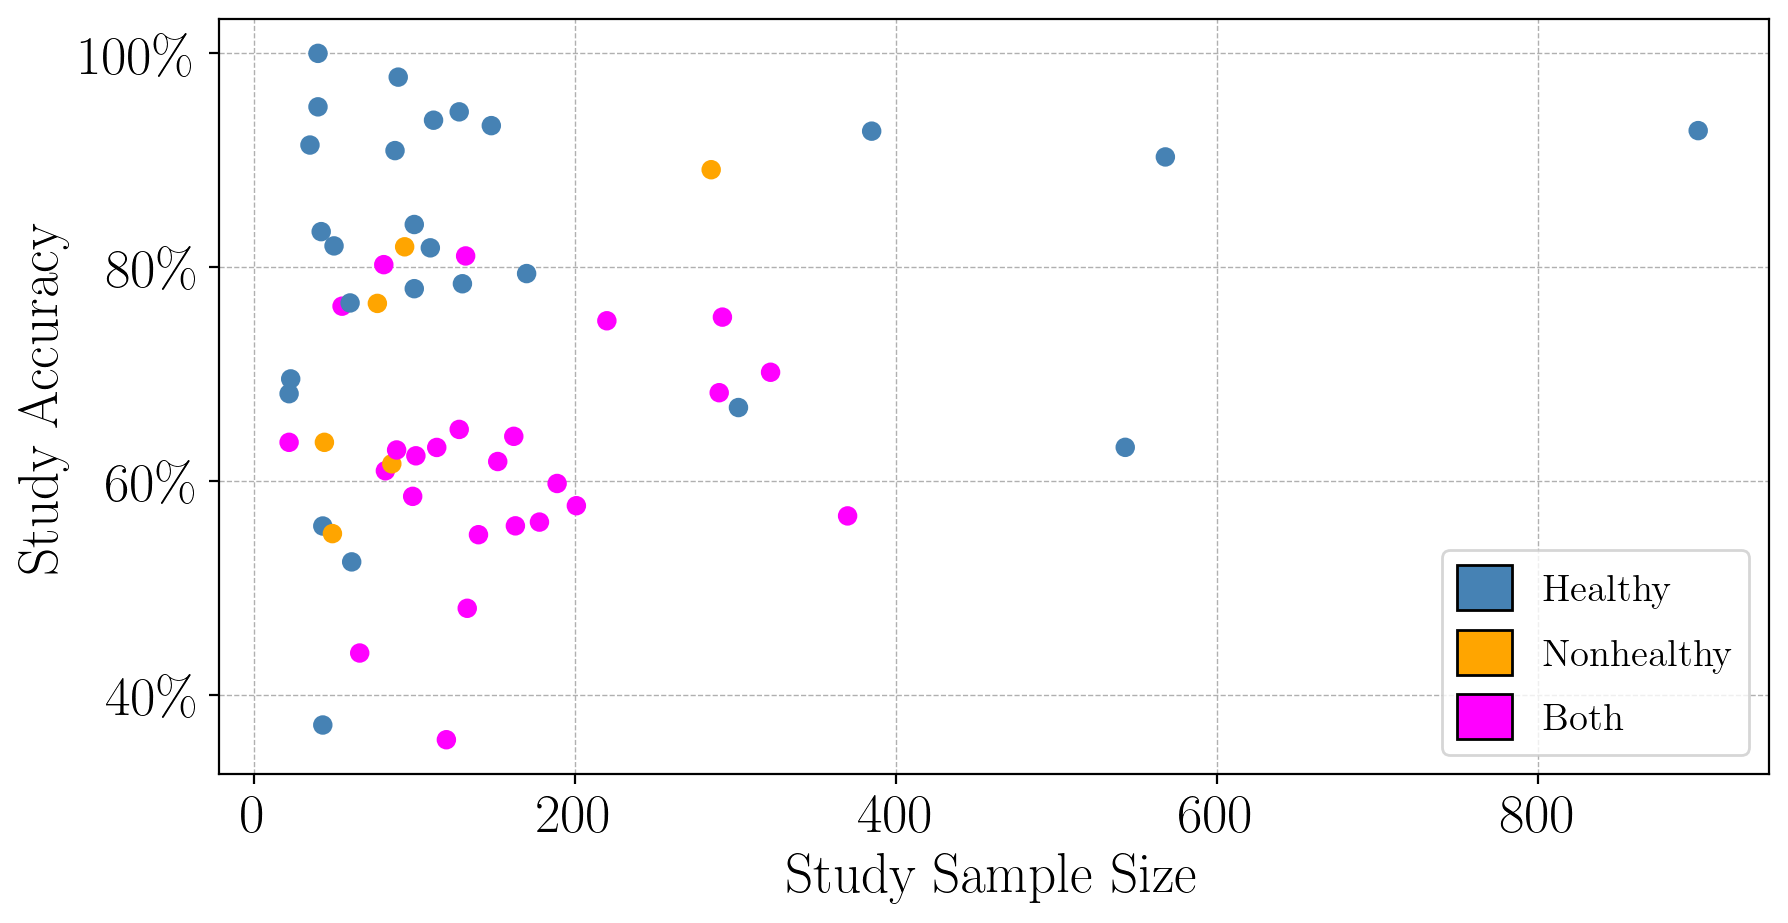

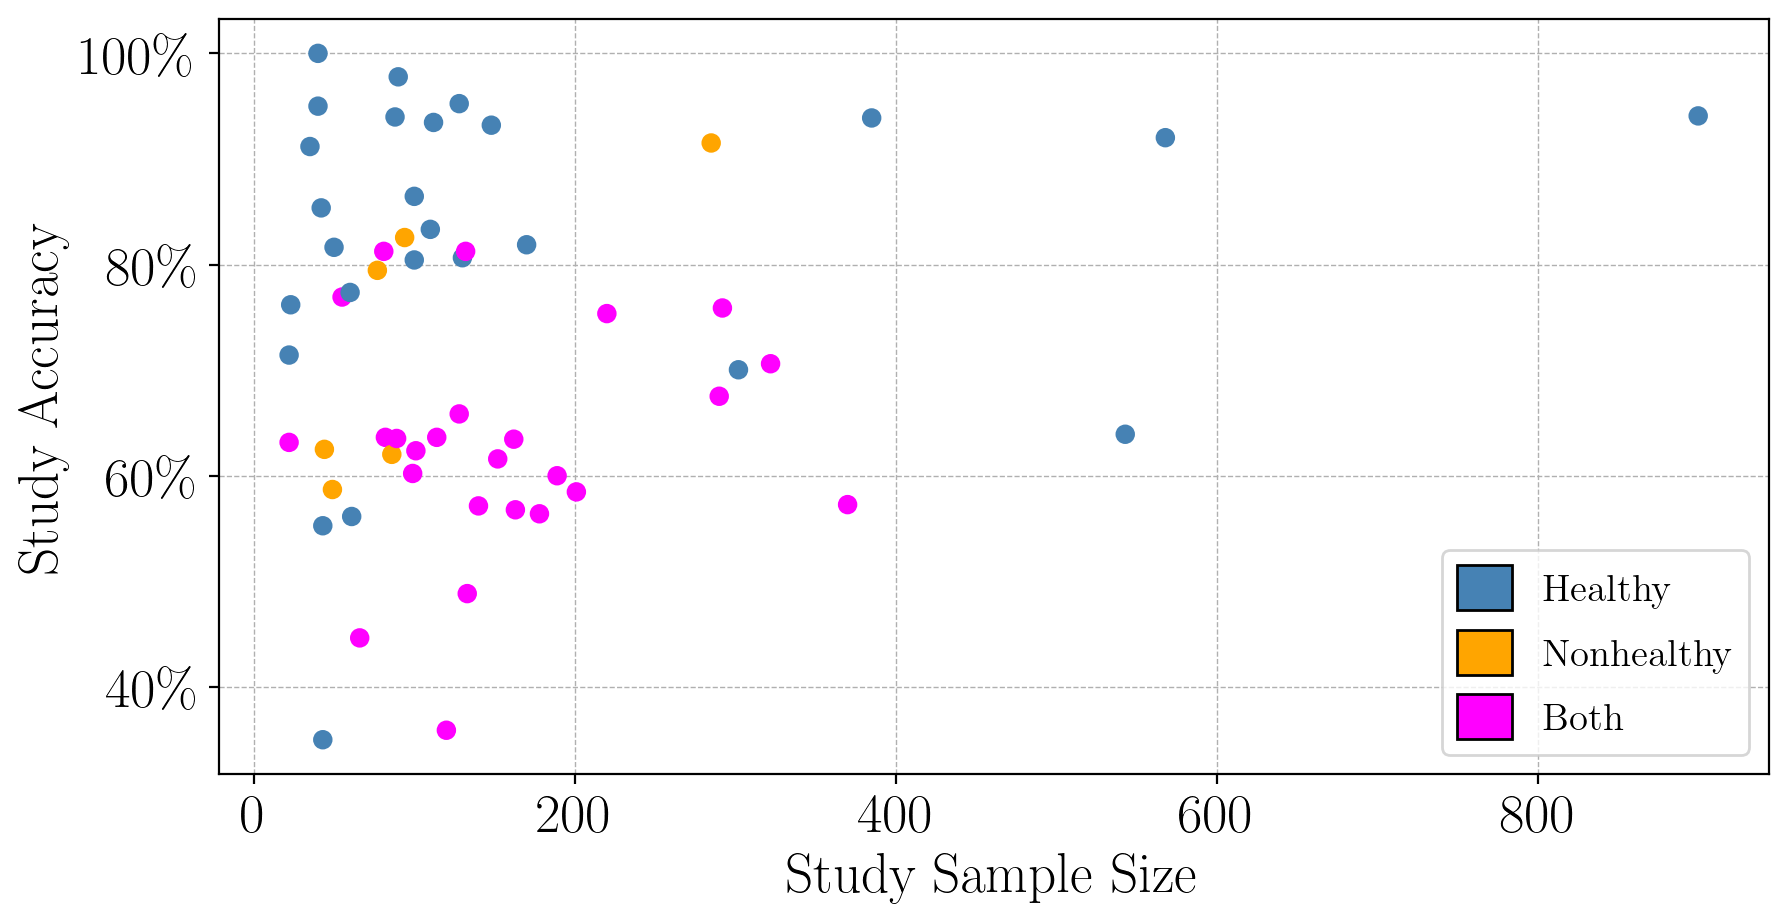

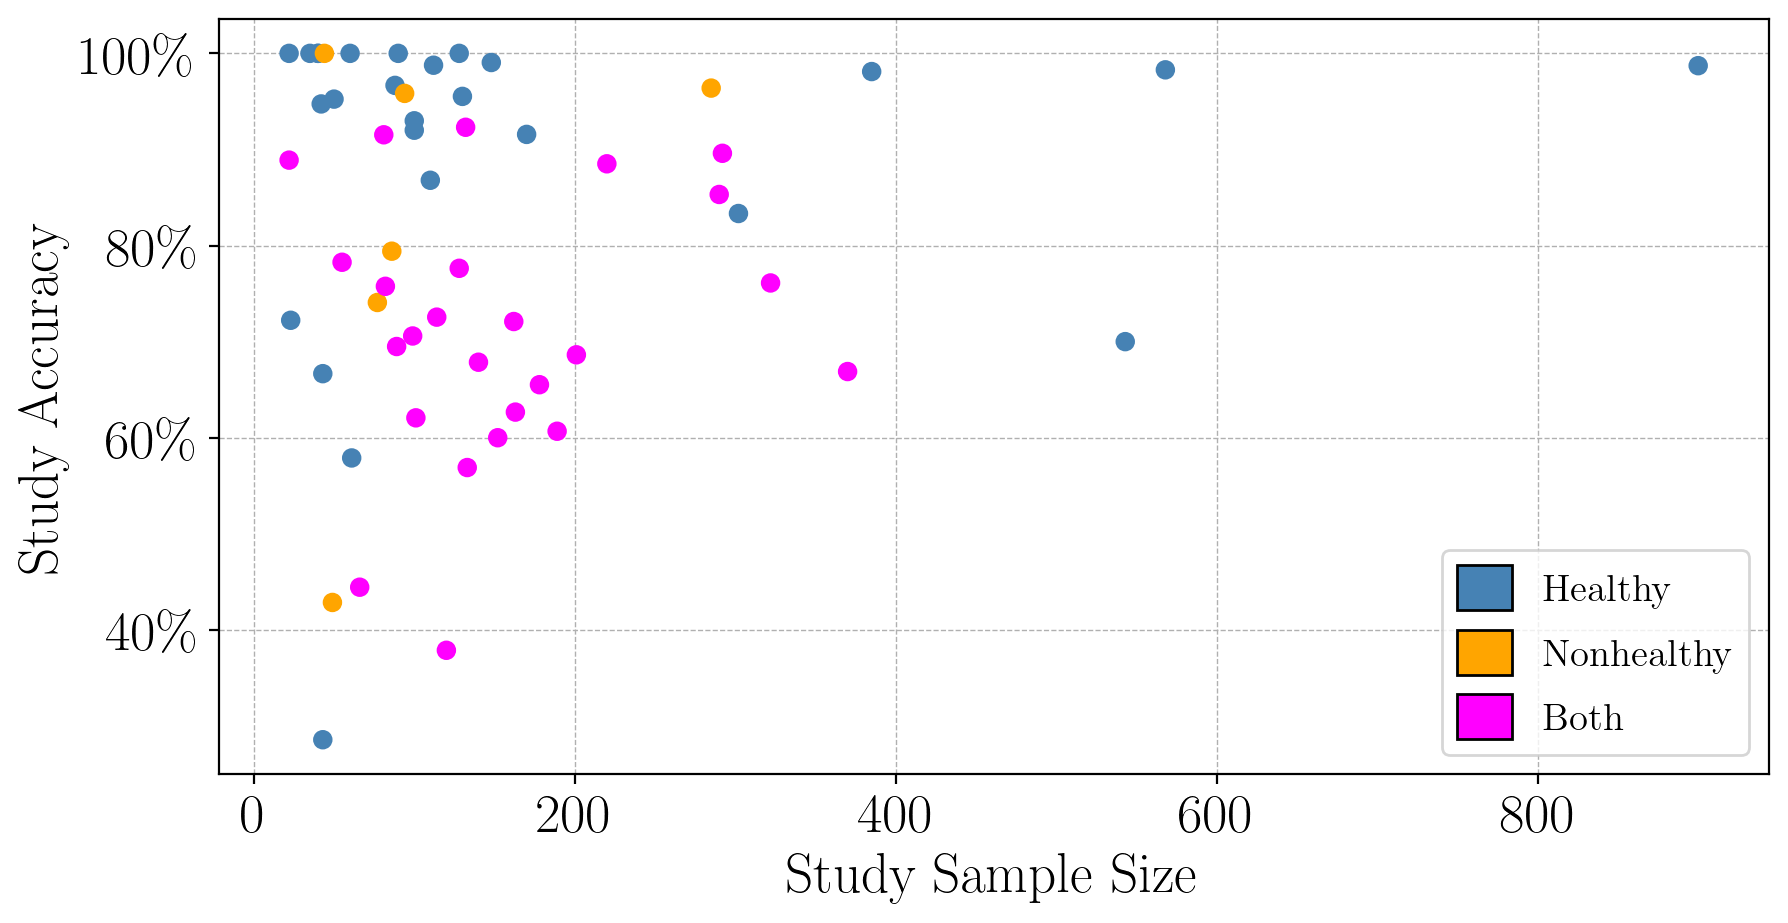

In [40]:
plot_performance_per_study_scatter("Study Accuracy", accuracy_score, 0,
                                   "accuracy_per_study_scatter_cutoff=0.svg")
plot_performance_per_study_scatter("Study Accuracy", accuracy_score, 0.1,
                                   "accuracy_per_study_scatter_cutoff=0.1.svg")
plot_performance_per_study_scatter("Study Accuracy", accuracy_score, 1,
                                   "accuracy_per_study_scatter_cutoff=1.svg")